## Setup: Create PC1×PC2 decile grid

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load your PCs (assuming you have a DataFrame with 'IID', 'PC1', 'PC2', 'batch')
data_dir = Path("./data/plink/tapestry/genome_wide")
pcs = pd.read_csv(data_dir / "tapestry_pcs_with_metadata.tsv", sep='\t')

print(f"Loaded {pcs.shape[0]} samples")
print(f"Columns: {list(pcs.columns)}")

In [ ]:
# Create decile bins for PC1 and PC2
pcs['PC1_decile'] = pd.qcut(pcs['PC1'], q=10, labels=False, duplicates='drop')
pcs['PC2_decile'] = pd.qcut(pcs['PC2'], q=10, labels=False, duplicates='drop')

# Combine into single grid ID (0-99)
pcs['PC_grid'] = pcs['PC1_decile'] * 10 + pcs['PC2_decile']

print(f"Created {pcs['PC_grid'].nunique()} unique grid cells")
print(pcs[['#IID', 'PC1', 'PC2', 'PC1_decile', 'PC2_decile', 'PC_grid']].head())

<Axes: >

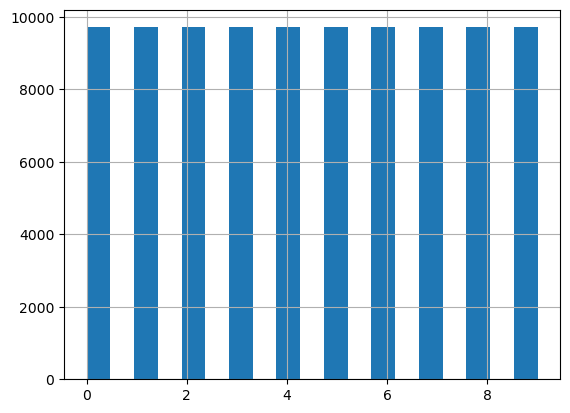

In [21]:
pcs['PC1_decile'].hist(bins=19)

<Axes: >

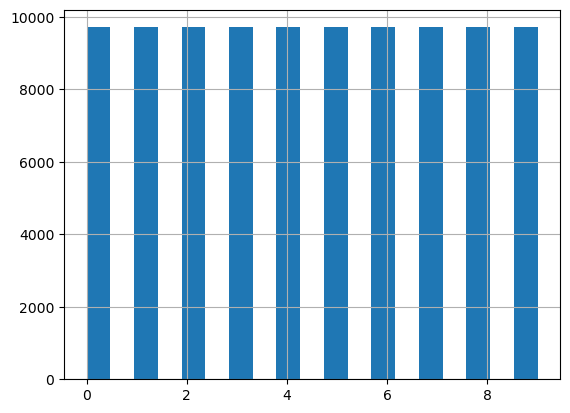

In [20]:
pcs['PC2_decile'].hist(bins=19)

<Axes: >

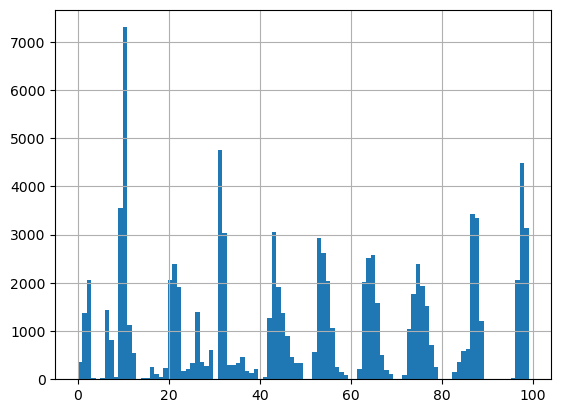

In [26]:
pcs['PC_grid'].hist(bins=100)

## Step 1: Check sample distribution across grid cells

In [14]:
# How many samples per grid cell?
grid_counts = pcs['PC_grid'].value_counts().sort_index()

print(f"Grid cells with samples: {len(grid_counts)} / 100")
print(f"\nSample distribution:")
print(f"  Min: {grid_counts.min()} samples")
print(f"  Median: {grid_counts.median()} samples")
print(f"  Max: {grid_counts.max()} samples")
print(f"\nTop 5 densest cells:")
print(grid_counts.head())

Grid cells with samples: 87 / 100

Sample distribution:
  Min: 3 samples
  Median: 505.0 samples
  Max: 7300 samples

Top 5 densest cells:
PC_grid
0.0     360
1.0    1374
2.0    2053
3.0      21
4.0      14
Name: count, dtype: int64


## Step 2: Visualize grid density

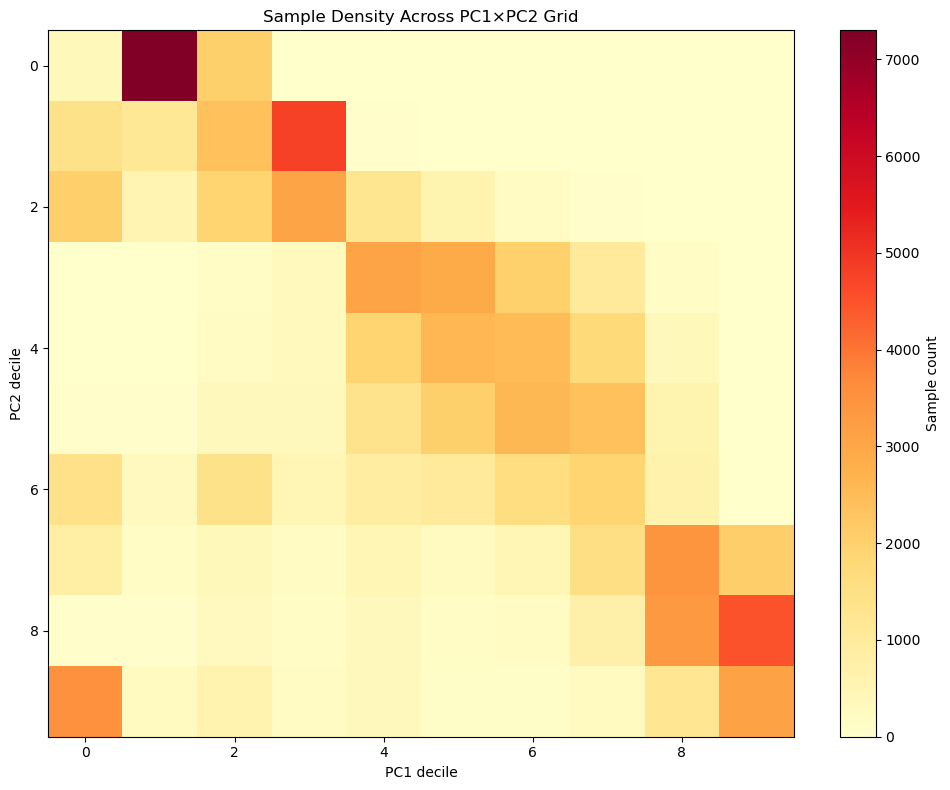

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create 10×10 heatmap of sample counts
grid_matrix = np.zeros((10, 10))
for grid_id, count in grid_counts.items():
    pc1_dec = int(grid_id // 10)
    pc2_dec = int(grid_id % 10)
    grid_matrix[pc2_dec, pc1_dec] = count  # note: y-axis inverted for heatmap

plt.figure(figsize=(10, 8))
plt.imshow(grid_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Sample count')
plt.xlabel('PC1 decile')
plt.ylabel('PC2 decile')
plt.title('Sample Density Across PC1×PC2 Grid')
plt.tight_layout()
plt.show()

## Step 3: Check batch distribution across cells

In [16]:
# How does batch spread across grid?
grid_batch = pcs.groupby(['PC_grid', 'VCF_ASSAY_VERSION']).size().unstack(fill_value=0)

# Which cells have batch imbalance? (>80% from one assay version)
batch_props = grid_batch.div(grid_batch.sum(axis=1), axis=0)
imbalanced = (batch_props.max(axis=1) > 0.8)

print(f"Cells with >80% batch dominance: {imbalanced.sum()} / {len(grid_batch)}")
print(f"\nExample imbalanced cells:")
print(batch_props[imbalanced].head(10))

Cells with >80% batch dominance: 80 / 87

Example imbalanced cells:
VCF_ASSAY_VERSION        v2        v3        v4        v6
PC_grid                                                  
0.0                0.000000  1.000000  0.000000  0.000000
1.0                0.000000  1.000000  0.000000  0.000000
2.0                0.000000  1.000000  0.000000  0.000000
3.0                0.000000  0.857143  0.142857  0.000000
6.0                0.000000  0.034722  0.965278  0.000000
7.0                0.000000  0.101840  0.884663  0.013497
10.0               0.000137  0.999863  0.000000  0.000000
11.0               0.000000  1.000000  0.000000  0.000000
12.0               0.000000  0.990926  0.009074  0.000000
13.0               0.000000  0.000000  1.000000  0.000000
